In [1]:
import pyximport
pyximport.install()
from MMplot import Blackstyle as Bs
import pysam
from scHiC.seq_mismatches import get_mismatches_c
import re
import os
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import pandas as pd
import matplotlib

# Define functions

In [10]:
def getMissmatches(algn, mate, qual=30):
    """Takes a pysam alignment and will return the number of AG or TC 
    mutations that
    have an equal or higher Phred score than the qual parameters."""
    seq = algn.query_sequence.upper()
    quals = algn.query_qualities
    aligned_pairs = algn.get_aligned_pairs(with_seq=True, matches_only=True)
    mismatches = get_mismatches_c(seq, quals, aligned_pairs)
    n_AG_muts = 0
    n_TC_muts = 0
    nMuts = 0
    for mm in mismatches:
        if mm[2] >= qual:
            nMuts += 1
        if (mm[0] == 'A' and mm[1] == 'G'):
            if mm[2] >= qual:
                n_AG_muts += 1
        elif (mm[0] == 'T' and mm[1] == 'C'):
            if mm[2] >= qual:
                n_TC_muts += 1
    return {f"AG_{mate}": n_AG_muts, f"TC_{mate}": n_TC_muts,
            f"N_muts_{mate}": nMuts}


def decideLabeledHalf(row, read="1", th=2, otherMutTh=0):
    """To be used with pandas.DataFrame.apply() to be applied to every
     row of a dataframe"""
    mutType1 = row[f"AG_{read}"]
    mutType2 = row[f"TC_{read}"]
    totalMut = row[f"N_muts_{read}"]
    if (mutType1 >= th) != (mutType2 >= th):  # != use as xor
        if mutType1 >= th:
            otherMut = totalMut - mutType1
        if mutType2 >= th:
            otherMut = totalMut - mutType2
        if otherMut > otherMutTh:
            return False
        return True
    return False


def isMatePairGood(mate1, mate2, qual, qqual, alignHalfLen):
    """Checks whether matepair passes filtering criteria"""
    # check if both mates are aligned
    if mate1.is_unmapped or mate2.is_unmapped:
        return False
    # do quality filtering
    if (mate1.mapq <= qual) or (np.mean(mate1.query_qualities) <= qqual):
        return False
    if (mate2.mapq <= qual) or (np.mean(mate2.query_qualities) <= qqual):
        return False
    # check if alignments are long enough
    if len(mate1.get_reference_sequence()) < alignHalfLen:
        return False
    if len(mate2.get_reference_sequence()) < alignHalfLen:
        return False
    return True


def countDoublyLabeledReads(samFiles, qual=20, qqual=0, posqual=30, alignHalfLen=240, stopCount=3000, infoTh=2, noiseTh=1):
    """Takes dictionary of files and counts the number of labeled reads
    based on the filtering criteria.
    qual --> minimum alignment quality of read
    qqual --> minimum average phred-score of read
    posQual --> minimum phredscore of point mutation
    alignHalfLen --> minimum length of read
    stopCount --> number of reads to consider
    infoTh --> minimum number of informative reads on half read to be called labelled
    noiseTh --> maximum number of noninformative mutations on half read to be called labelled"""
    output = []
    for barcode, samF in samFiles.items():
        print(samF)
        with pysam.AlignmentFile(samF, "r") as file1:
            readnumb = 0
            for mate1 in file1:
                # check whether read is first in pair
                if not mate1.is_read1:
                    continue
                # search for mate
                found = False
                badPair = False
                while not found:
                    mate2 = next(file1)
                    if mate2.query_name != mate1.query_name:
                        badPair = True
                        break
                    if mate2.is_read2:
                        found = True
                if badPair:
                    continue
                if readnumb >= stopCount:
                    break
                # check if both mates pass filters
                if not isMatePairGood(mate1, mate2, qual, qqual, alignHalfLen):
                    continue
                readnumb += 1
                mutsMate1 = getMissmatches(mate1, "1", posqual)
                mutsMate2 = getMissmatches(mate2, "2", posqual)
                temp = {**mutsMate1, **mutsMate2}
                temp.update({"barcode": barcode})
                output.append(temp)
    # make output dataframe
    outFrame = pd.DataFrame(output)
    outFrame.loc[:, "lab1"] = outFrame.apply(decideLabeledHalf, read="1",  th=infoTh, otherMutTh=noiseTh, axis=1)
    outFrame.loc[:, "lab2"] = outFrame.apply(decideLabeledHalf, read="2",th=infoTh, otherMutTh=noiseTh, axis=1)
    outFrame.loc[:, "both"] = outFrame["lab1"] & outFrame["lab2"]
    return outFrame


# Load samples

In [3]:
repDir1 = "/groups/gerlich/experiments/Experiments_004600/004615/bwa_results"


# define sample mapping

sampleMapping = {"AGTCAA": "No Release control",
                 "AGTTCC": "No Release 4sT",
                 "ATGTCA": "2h Release 4sT",
                 "CCGTCC": "4h Release 4sT",
                 "GTCCGC": "8h Release 4sT",
                 "GTGAAA": "G2 4sT"}

# Define samfiles to be compared

matchString = re.compile(r".*.sam")


samFiles = {}

for samFile in (i for i in os.listdir(repDir1) if matchString.search(i)):
    barcode = samFile[:6]
    if barcode not in sampleMapping:
        continue
    samFiles[sampleMapping[barcode]] = os.path.join(repDir1, samFile)

In [13]:
repDirs2 = ["/scratch-cbe/users/christoph.langer/nf-workdir/4638-Novaseq/4638-Novaseq/bwa_results/", 
            "/groups/gerlich/experiments/Experiments_004600/004605/bwa_results"]


# define sample mapping

sampleMapping2 = {"ATCACG": "No Release control",
                  "CGATGT": "No Release 4sT",
                  "TTAGGC": "2h Release 4sT",
                  "TGACCA": "4h Release 4sT",
                  "ACAGTG": "8h Release 4sT",
                  "GCCAAT": "G2 4sT"}

# Define samfiles to be compared

matchString = re.compile(r".*.sam")


samFiles2 = {}

for directory in repDirs2:
    for samFile in (i for i in os.listdir(directory) if matchString.search(i)):
        barcode = samFile[:6]
        if barcode not in sampleMapping2:
            continue
        samFiles2[sampleMapping2[barcode]] = os.path.join(directory, samFile)

In [14]:
samFiles2

{'8h Release 4sT': '/scratch-cbe/users/christoph.langer/nf-workdir/4638-Novaseq/4638-Novaseq/bwa_results/ACAGTG_S7_bwa.sam',
 'No Release 4sT': '/scratch-cbe/users/christoph.langer/nf-workdir/4638-Novaseq/4638-Novaseq/bwa_results/CGATGT_S4_bwa.sam',
 '4h Release 4sT': '/scratch-cbe/users/christoph.langer/nf-workdir/4638-Novaseq/4638-Novaseq/bwa_results/TGACCA_S6_bwa.sam',
 '2h Release 4sT': '/scratch-cbe/users/christoph.langer/nf-workdir/4638-Novaseq/4638-Novaseq/bwa_results/TTAGGC_S5_bwa.sam',
 'No Release control': '/scratch-cbe/users/christoph.langer/nf-workdir/4638-Novaseq/4638-Novaseq/bwa_results/ATCACG_S3_bwa.sam',
 'G2 4sT': '/groups/gerlich/experiments/Experiments_004600/004605/bwa_results/GCCAAT_S1_bwa.sam'}

# Get number of doubly labeled reads from both replicates

In [15]:
rep1Lab = countDoublyLabeledReads(samFiles, stopCount=100000)

/groups/gerlich/experiments/Experiments_004600/004615/bwa_results/GTCCGC_S6_bwa.sam
/groups/gerlich/experiments/Experiments_004600/004615/bwa_results/ATGTCA_S3_bwa.sam
/groups/gerlich/experiments/Experiments_004600/004615/bwa_results/GTGAAA_S7_bwa.sam
/groups/gerlich/experiments/Experiments_004600/004615/bwa_results/AGTCAA_S1_bwa.sam
/groups/gerlich/experiments/Experiments_004600/004615/bwa_results/CCGTCC_S4_bwa.sam
/groups/gerlich/experiments/Experiments_004600/004615/bwa_results/AGTTCC_S2_bwa.sam


In [16]:
rep2Lab = countDoublyLabeledReads(samFiles2, stopCount=100000)

/scratch-cbe/users/christoph.langer/nf-workdir/4638-Novaseq/4638-Novaseq/bwa_results/ACAGTG_S7_bwa.sam
/scratch-cbe/users/christoph.langer/nf-workdir/4638-Novaseq/4638-Novaseq/bwa_results/CGATGT_S4_bwa.sam
/scratch-cbe/users/christoph.langer/nf-workdir/4638-Novaseq/4638-Novaseq/bwa_results/TGACCA_S6_bwa.sam
/scratch-cbe/users/christoph.langer/nf-workdir/4638-Novaseq/4638-Novaseq/bwa_results/TTAGGC_S5_bwa.sam
/scratch-cbe/users/christoph.langer/nf-workdir/4638-Novaseq/4638-Novaseq/bwa_results/ATCACG_S3_bwa.sam
/groups/gerlich/experiments/Experiments_004600/004605/bwa_results/GCCAAT_S1_bwa.sam


# Pool samples and calculate mean percentage of doubly labelled reads

In [17]:
pooledLab = pd.concat((rep1Lab, rep2Lab))

# calculate percentage double

grouped = pooledLab.groupby("barcode").mean().reset_index()
grouped.loc[:, "both"] = grouped["both"] * 100

# Plot result

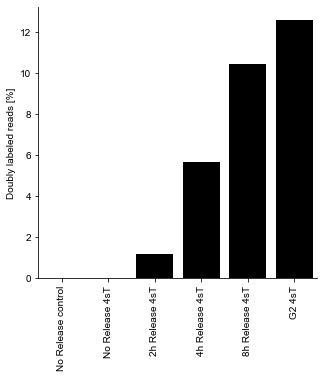

In [19]:
order = ["No Release control", "No Release 4sT", "2h Release 4sT", "4h Release 4sT", "8h Release 4sT", "G2 4sT"]

f, ax = plt.subplots()
sbn.barplot(x="barcode", y="both", data=grouped, order=order, ax=ax, color="black")
locs, labels = plt.xticks()
plt.xticks(locs, labels, rotation=90)
ax.set_xlabel("")
ax.set_ylabel("Doubly labeled reads [%]")
f.set_size_inches(5, 5)
sbn.despine()
plt.show()